Análisis de la clasificación del Titanic usando boosted trees
===

* *30 min* | Última modificación: Abril 8, 2020.

Basado en https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print(tf.__version__)

#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.1.0


## Carga y configuración del dataset

In [2]:
#
#  Carga del dataset
#
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop("survived")
y_eval = dfeval.pop("survived")

#
#  Verificación.
#
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


## Semilla del generador de números aleatorios

In [3]:
tf.random.set_seed(123)

## Construcción del estimador

In [4]:
CATEGORICAL_COLUMNS = [
    "sex",
    "n_siblings_spouses",
    "parch",
    "class",
    "deck",
    "embark_town",
    "alone",
]

NUMERIC_COLUMNS = ["age", "fare"]


def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab)
    )


#
#  Se genera una lista que tiene el tipo de cada columna
#
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )

In [5]:
NUM_EXAMPLES = len(y_train)


def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(NUM_EXAMPLES)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds

    return input_function


train_input_fn = make_input_fn(dftrain, y_train)

eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [6]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

est.train(train_input_fn, max_steps=100)

In [7]:
results = est.evaluate(eval_input_fn)

pd.Series(results).to_frame()

,0
accuracy,0.734848
accuracy_baseline,0.625000
auc,0.819345
auc_precision_recall,0.761192
average_loss,0.494756
label/mean,0.375000
loss,0.480973
precision,0.659341
prediction/mean,0.383650
recall,0.606061


## Análisis

In [9]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

labels = y_eval.values

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])

df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,264.0,-0.020522,0.154280,-0.250366,-0.131928,-0.101715,0.131170,0.323551
class,264.0,-0.001452,0.099613,-0.166197,-0.074558,-0.055880,0.102376,0.269381
age,264.0,0.010371,0.100155,-0.371482,-0.047418,-0.004958,0.080293,0.297075
deck,264.0,-0.036994,0.055682,-0.322857,-0.059749,-0.041687,-0.031586,0.207330
n_siblings_spouses,264.0,0.029868,0.040258,-0.092343,0.015465,0.022228,0.048924,0.131723
embark_town,264.0,-0.020736,0.029902,-0.195621,-0.023443,-0.017374,-0.013929,0.040633
alone,264.0,0.004163,0.047366,-0.120268,-0.024474,-0.015169,0.046422,0.163561
fare,264.0,0.064955,0.078269,-0.046427,0.003521,0.052748,0.103028,0.445784
parch,264.0,0.010247,0.032331,-0.123747,0.000981,0.002762,0.037567,0.080879


In [10]:
#
#  Sum of DFCs + bias == probabality.
#
bias = pred_dicts[0]["bias"]
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [11]:
#
#  Funciones auxiliares para graficación
# 
def _get_color(value):
    green, red = sns.color_palette()[2:4]
    if value >= 0:
        return green
    return red


def _add_feature_values(feature_values, ax):
    
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, "{}".format(feat_val), size=12)
        t.set_bbox(dict(facecolor="white", alpha=0.5))
        
    from matplotlib.font_manager import FontProperties

    font = FontProperties()
    font.set_weight("bold")
    t = plt.text(
        x_coord, y_coord + 1 - OFFSET, "feature\nvalue", fontproperties=font, size=12
    )


def plot_example(example):
    TOP_N = 8
    sorted_ix = example.abs().sort_values()[-TOP_N:].index 
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(
        kind="barh", color=[colors], legend=None, alpha=0.75, figsize=(10, 6)
    )
    ax.grid(False, axis="y")
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

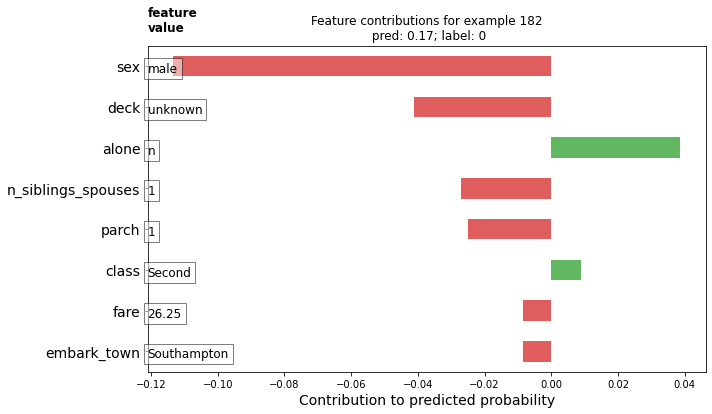

In [12]:

ID = 182

example = df_dfc.iloc[ID]  

TOP_N = 8  
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [13]:


sns_colors = sns.color_palette('colorblind')

def dist_violin_plot(df_dfc, ID):
    # Initialize plot.
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Create example dataframe.
    TOP_N = 8  # View top 8 features.
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name="dfc")

    # Add contributions of entire distribution.
    parts = ax.violinplot(
        [df_dfc[w] for w in ix],
        vert=False,
        showextrema=False,
        widths=0.7,
        positions=np.arange(len(ix)),
    )
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts["bodies"]:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # Add feature values.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

    # Add local contributions.
    ax.scatter(
        example,
        np.arange(example.shape[0]),
        color=sns.color_palette()[2],
        s=100,
        marker="s",
        label="contributions for example",
    )

    # Legend
    # Proxy plot, to show violinplot dist on legend.
    ax.plot(
        [0, 0],
        [1, 1],
        label="eval set contributions\ndistributions",
        color=face_color,
        alpha=alpha,
        linewidth=10,
    )
    legend = ax.legend(loc="lower right", shadow=True, fontsize="x-large", frameon=True)
    legend.get_frame().set_facecolor("white")

    # Format plot.
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis="y")
    ax.set_xlabel("Contribution to predicted probability", size=14)

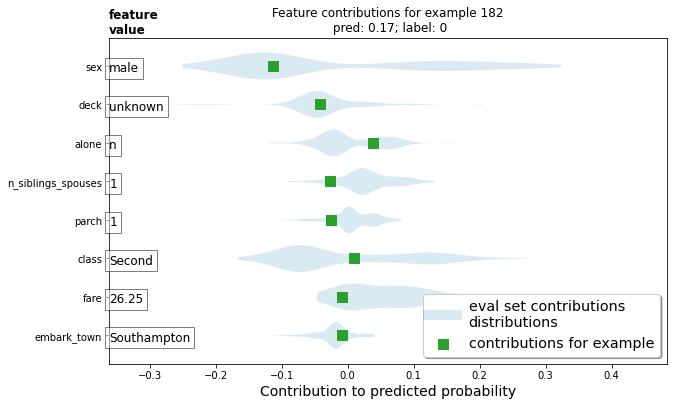

In [14]:
dist_violin_plot(df_dfc, ID)
plt.title(
    "Feature contributions for example {}\n pred: {:1.2f}; label: {}".format(
        ID, probs[ID], labels[ID]
    )
)
plt.show()

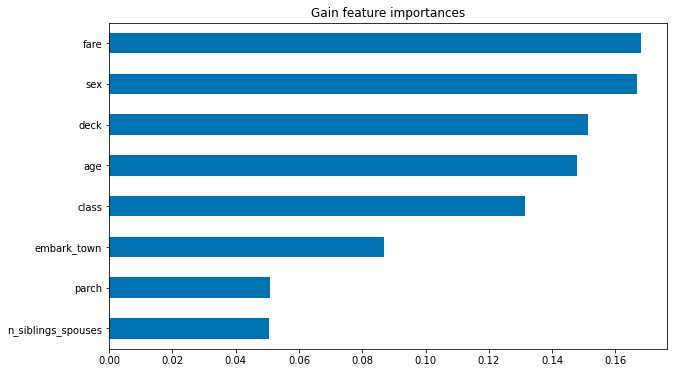

In [15]:
importances = est.experimental_feature_importances(normalize=True)

df_imp = pd.Series(importances)

N = 8
ax = df_imp.iloc[0:N][::-1].plot(
    kind="barh", color=sns_colors[0], title="Gain feature importances", figsize=(10, 6)
)
ax.grid(False, axis="y")

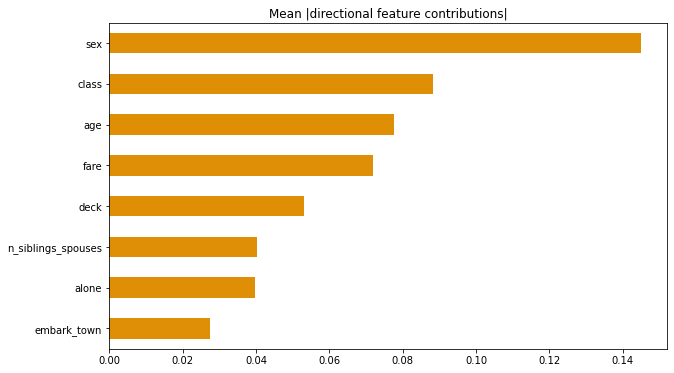

In [16]:
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index
ax = dfc_mean[sorted_ix].plot(
    kind="barh",
    color=sns_colors[1],
    title="Mean |directional feature contributions|",
    figsize=(10, 6),
)
ax.grid(False, axis="y")

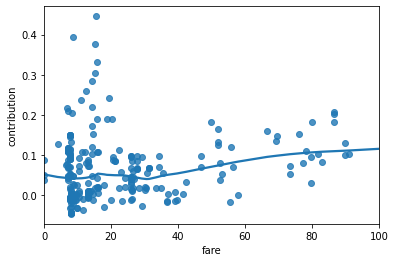

In [17]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

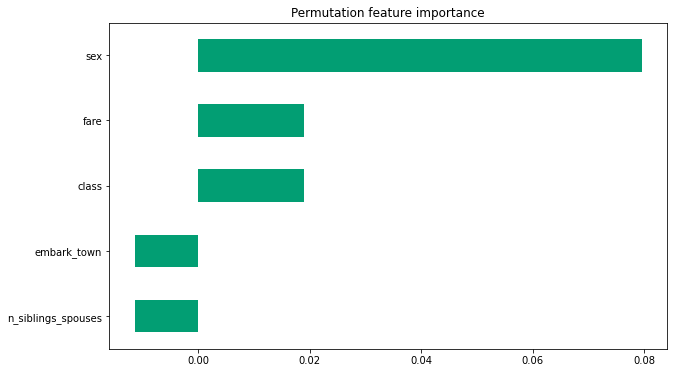

In [18]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)


def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(data_df=X, label_df=y, shuffle=False)
    result = est.evaluate(input_fn=eval_input_fn)["accuracy"]
    return result


features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric, features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind="barh", color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis="y")
ax.set_title("Permutation feature importance")
plt.show()

In [19]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x * np.exp(-(x ** 2) - y ** 2)
xy = np.zeros((2, np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [20]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [21]:
def plot_contour(x, y, z, **kwargs):

    plt.figure(figsize=(10, 8))

    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors="k")
    CS = plt.contourf(
        x, y, z, 15, vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap="RdBu_r"
    )
    
    plt.colorbar()
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

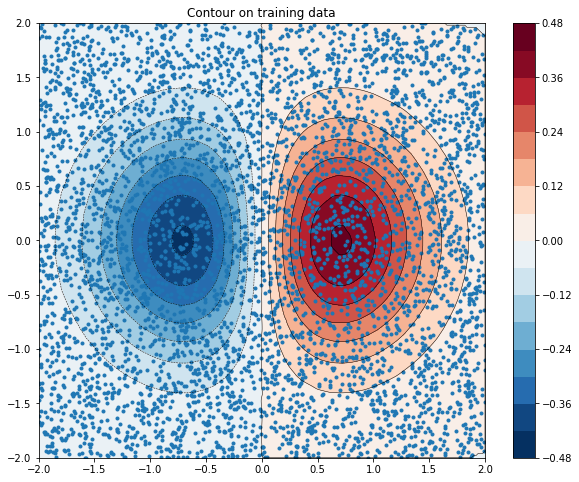

In [22]:
zi = griddata(xy, z, (xi, yi), method="linear", fill_value="0")
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker=".")
plt.title("Contour on training data")
plt.show()

In [23]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [24]:
def predict(est):
    """Predictions from a given estimator."""
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p["predictions"][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

In [25]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

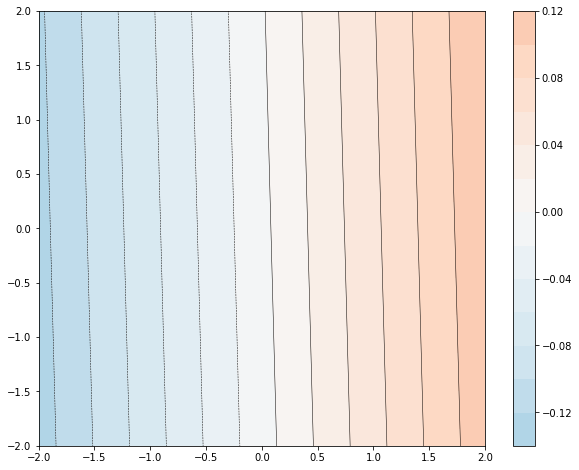

In [26]:
plot_contour(xi, yi, predict(est))

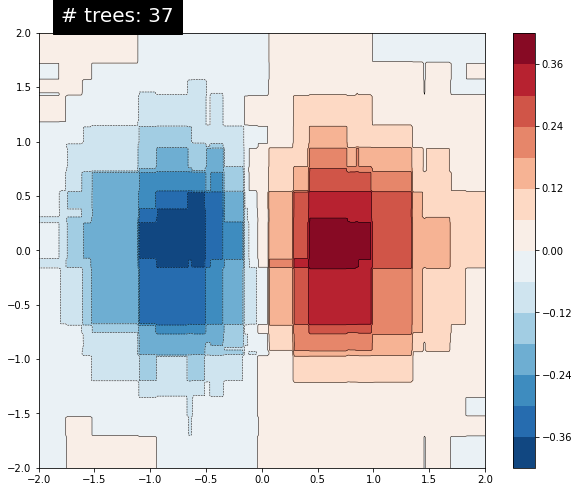

In [27]:
n_trees = 37 #@param {type: "slider", min: 1, max: 80, step: 1}

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)

plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()